# Home 4: Build a CNN for image recognition.

### Name: Tara Lozy


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


Normalize the pixel values by dividing the data by 255

In [2]:
# normalizing the data so the values fall between 0 and 1
x_train = x_train / 255.0 
x_test = x_test / 255.0 

### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [3]:
def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, y in enumerate(y):
        results[i, y] = 1.
    return results 


y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [4]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


In [5]:
# batch augmentation 
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,)

In [6]:
train_generator = train_datagen.flow(x_tr, y_tr, batch_size=32)  #training augmentation

In [7]:
validation_generator = train_datagen.flow(x_val, y_val, batch_size=32)  #validation augmentation

## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [18]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 64)       

In [10]:
# In order to tune the learning rate, I checked the performance of the model with a learning rate of 1E-4, 1E-5 and 1E-6
from keras import optimizers

learning_rate = 1E-6 # to be tuned!

    
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=learning_rate),
                metrics=['acc'])

history_2 = model.fit(train_generator, steps_per_epoch = 1250, epochs=10, validation_data=(validation_generator))

Epoch 1/10
1250/1250 [==============================] - 128s 102ms/step - loss: 2.4015 - acc: 0.1460 - val_loss: 2.2689 - val_acc: 0.1826
Epoch 2/10
1250/1250 [==============================] - 125s 100ms/step - loss: 2.2021 - acc: 0.2078 - val_loss: 2.1222 - val_acc: 0.2357
Epoch 3/10
1250/1250 [==============================] - 142s 114ms/step - loss: 2.0825 - acc: 0.2544 - val_loss: 2.0356 - val_acc: 0.2747
Epoch 4/10
1250/1250 [==============================] - 135s 108ms/step - loss: 2.0154 - acc: 0.2786 - val_loss: 1.9732 - val_acc: 0.2936
Epoch 5/10
1250/1250 [==============================] - 126s 101ms/step - loss: 1.9580 - acc: 0.3010 - val_loss: 1.9181 - val_acc: 0.3149
Epoch 6/10
1250/1250 [==============================] - 139s 111ms/step - loss: 1.9084 - acc: 0.3175 - val_loss: 1.8725 - val_acc: 0.3332
Epoch 7/10
1250/1250 [==============================] - 129s 103ms/step - loss: 1.8708 - acc: 0.3334 - val_loss: 1.8467 - val_acc: 0.3360
Epoch 8/10
1250/1250 [============

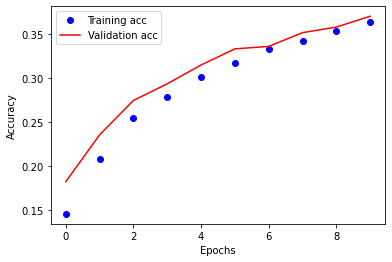

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history_2.history['acc']
val_acc = history_2.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

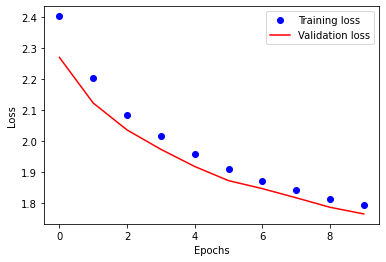

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
from keras import optimizers

learning_rate = 1E-4 # to be tuned!

    
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=learning_rate),
                metrics=['acc'])

history_3 = model.fit(train_generator, steps_per_epoch = 1250, epochs=10, validation_data=(validation_generator))

Epoch 1/10
1250/1250 [==============================] - 117s 94ms/step - loss: 1.5471 - acc: 0.4527 - val_loss: 1.3618 - val_acc: 0.5143
Epoch 2/10
1250/1250 [==============================] - 119s 95ms/step - loss: 1.2251 - acc: 0.5680 - val_loss: 1.2441 - val_acc: 0.5723
Epoch 3/10
1250/1250 [==============================] - 120s 96ms/step - loss: 1.0955 - acc: 0.6151 - val_loss: 1.0808 - val_acc: 0.6186
Epoch 4/10
1250/1250 [==============================] - 120s 96ms/step - loss: 1.0135 - acc: 0.6444 - val_loss: 1.0890 - val_acc: 0.6205
Epoch 5/10
1250/1250 [==============================] - 119s 95ms/step - loss: 0.9555 - acc: 0.6681 - val_loss: 1.0879 - val_acc: 0.6253
Epoch 6/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.9049 - acc: 0.6833 - val_loss: 0.9328 - val_acc: 0.6766
Epoch 7/10
1250/1250 [==============================] - 120s 96ms/step - loss: 0.8643 - acc: 0.6996 - val_loss: 0.9458 - val_acc: 0.6668
Epoch 8/10
1250/1250 [===================

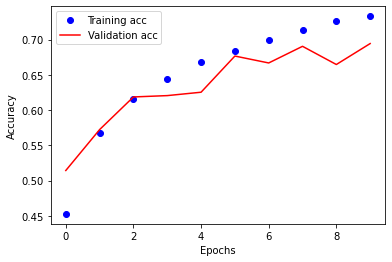

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history_3.history['acc']
val_acc = history_3.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

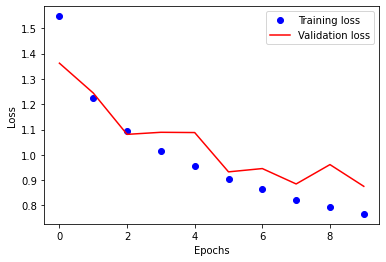

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
from keras import optimizers

learning_rate = 1E-5 # to be tuned!

    
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=learning_rate),
                metrics=['acc'])
    

In [15]:
history = model.fit(train_generator, steps_per_epoch = 1250, epochs=10, validation_data=(validation_generator))

Epoch 1/10
1250/1250 [==============================] - 117s 94ms/step - loss: 2.0148 - acc: 0.2922 - val_loss: 1.7684 - val_acc: 0.3820
Epoch 2/10
1250/1250 [==============================] - 119s 96ms/step - loss: 1.7169 - acc: 0.3961 - val_loss: 1.6224 - val_acc: 0.4274
Epoch 3/10
1250/1250 [==============================] - 130s 104ms/step - loss: 1.5987 - acc: 0.4385 - val_loss: 1.5281 - val_acc: 0.4644
Epoch 4/10
1250/1250 [==============================] - 130s 104ms/step - loss: 1.5278 - acc: 0.4654 - val_loss: 1.4742 - val_acc: 0.4817
Epoch 5/10
1250/1250 [==============================] - 124s 99ms/step - loss: 1.4737 - acc: 0.4809 - val_loss: 1.4252 - val_acc: 0.4969
Epoch 6/10
1250/1250 [==============================] - 125s 100ms/step - loss: 1.4287 - acc: 0.4990 - val_loss: 1.3914 - val_acc: 0.5072
Epoch 7/10
1250/1250 [==============================] - 123s 98ms/step - loss: 1.3913 - acc: 0.5115 - val_loss: 1.3529 - val_acc: 0.5256
Epoch 8/10
1250/1250 [================

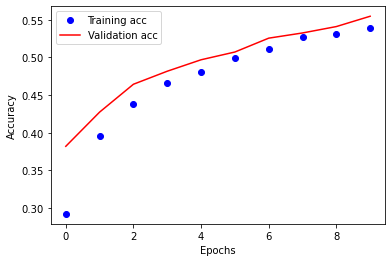

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

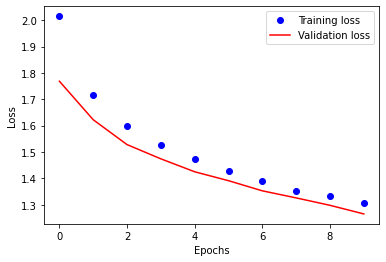

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

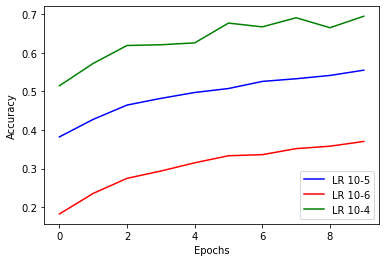

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

val_acc = history.history['val_acc']
val_acc_2 = history_2.history['val_acc']
val_acc_3 = history_3.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, val_acc, 'b', label='LR 10-5')
plt.plot(epochs, val_acc_2, 'r', label='LR 10-6')
plt.plot(epochs, val_acc_3, 'g', label = 'LR 10-4')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

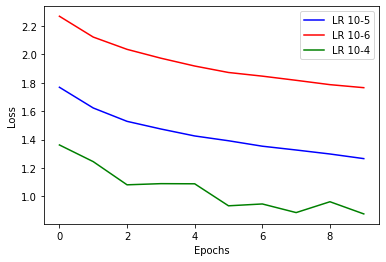

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

val_loss = history.history['val_loss']
val_loss_2 = history_2.history['val_loss']
val_loss_3 = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, val_loss, 'b', label='LR 10-5')
plt.plot(epochs, val_loss_2, 'r', label='LR 10-6')
plt.plot(epochs, val_loss_3, 'g', label = 'LR 10-4')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model seems to perform better a lower learning rate but the convergence is a lot slower. Since I am using 10 epochs, I have chosen to use a learning rate of 1E-4. I know it's bouncing around slightly but it has the highest accuracy. 

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [24]:
#<Compile your model again (using the same hyper-parameters)>

from keras import optimizers

learning_rate = 1E-4 # selected from previous section

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [25]:
train1_generator = train_datagen.flow(x_train, y_train_vec, batch_size=32) #entire training set augmentation 

In [26]:
#<Train your model on the entire training set (50K samples)>
#<Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
#<Do NOT use the validation_data option (because now you do not have validation data)>
#...
training = model.fit(train1_generator, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 138s 88ms/step - loss: 0.7586 - acc: 0.7391
Epoch 2/10
1563/1563 [==============================] - 137s 88ms/step - loss: 0.7353 - acc: 0.7447
Epoch 3/10
1563/1563 [==============================] - 138s 88ms/step - loss: 0.7117 - acc: 0.7524
Epoch 4/10
1563/1563 [==============================] - 139s 89ms/step - loss: 0.6857 - acc: 0.7634
Epoch 5/10
1563/1563 [==============================] - 141s 90ms/step - loss: 0.6681 - acc: 0.7712
Epoch 6/10
1563/1563 [==============================] - 143s 92ms/step - loss: 0.6565 - acc: 0.7713
Epoch 7/10
1563/1563 [==============================] - 143s 92ms/step - loss: 0.6330 - acc: 0.7807
Epoch 8/10
1563/1563 [==============================] - 141s 90ms/step - loss: 0.6195 - acc: 0.7866
Epoch 9/10
1563/1563 [==============================] - 141s 90ms/step - loss: 0.6017 - acc: 0.7922
Epoch 10/10
1563/1563 [==============================] - 142s 91ms/step - loss: 0.5936 - acc: 0.7956

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [27]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 4s 13ms/step - loss: 0.7787 - acc: 0.7648
loss = 0.7787069082260132
accuracy = 0.7648000121116638
